In [ ]:
# initial imports
import plotly.express as px
import pandas as pd
import os
from pathlib import Path
from dotenv import load_dotenv
import panel as pn
import matplotlib.pyplot as plt
import hvplot.pandas
from panel.interact import interact

%matplotlib inline 

In [2]:
pn.extension('plotly')

In [3]:
 # Read the Mapbox API key
load_dotenv()
mapbox_token = os.getenv("MAPBOX_API_KEY")

In [4]:
# Import the CSVs to Pandas DataFrames
file_path = Path("Resources/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")

file_path = Path("Resources/neighborhoods_coordinates.csv")
df_neighborhood_locations = pd.read_csv(file_path)

In [5]:
##Panel Visualizations

def housing_units_per_year():
    """Housing Units Per Year."""

    
    housing_units = sfo_data["housing_units"]
    housing_units = housing_units.groupby([sfo_data.index]).mean()
    
    housing_units_fig = plt.figure()
    housing_units_plot = housing_units.plot.bar(x='year', ylim=[370000, 385000], title="Average Number of Housing Units Sold per Year")
    plt.close(housing_units_fig)
    
    return pn.pane.Matplotlib(housing_units_fig)

In [6]:
def average_gross_rent():  
    """Average Gross Rent in San Francisco Per Year."""
    

    
    average_rent_sqr_foot = sfo_data["gross_rent"].groupby([sfo_data.index]).mean()
    
    gross_rent_fig = plt.figure()
    average_rent_plot = (average_rent_sqr_foot.plot.line(x='year', y='gross_rent', title="Average Goss Rent per Year"))
    plt.close(gross_rent_fig)
    
    return pn.pane.Matplotlib(gross_rent_fig)

In [13]:
def average_sales_price():
    """Average Sales Price Per Year."""
    
    average_price_sqr_foot = sfo_data["sale_price_sqr_foot"].groupby([sfo_data.index]).mean()
    sales_price_fig = plt.figure()
    average_price_plot = (average_price_sqr_foot.plot.line(x='year', y='sale_price_sqr_foot', title="Average Sales Price per Year"))
    plt.close(sales_price_fig)
    
    return pn.pane.Matplotlib(sales_price_fig)

In [7]:

def average_price_by_neighborhood(neighborhood):
    """Average Prices by Neighborhood."""
    
    sfo_data_new = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
    sfo_sales = sfo_data_new["sale_price_sqr_foot"]
    sfo_sales_df = pd.DataFrame(sfo_sales).reset_index()
     
    
    return sfo_sales_df.loc[sfo_sales_df['neighborhood']==neighborhood,:].hvplot.line(
        x="year",
        y="sale_price_sqr_foot",
        colormap="coolwarm",
        title="SF Sale per Square foot per Year",
    )

sfo_data_new = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean()
sfo_sales = sfo_data_new["sale_price_sqr_foot"]
sfo_sales_df = pd.DataFrame(sfo_sales).reset_index()
neighborhood_choice = sfo_sales_df["neighborhood"].unique()
interact(average_price_by_neighborhood, neighborhood=neighborhood_choice)

Column
    [0] Column
        [0] Select(name='neighborhood', options=['Alamo Square', ...], value='Alamo Square')
    [1] Row
        [0] HoloViews(Curve, name='interactive01448')

In [8]:
def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""
    
    avg_value_per_neighborhood = sfo_data.groupby([sfo_data["neighborhood"]]).mean()
    avg_value_per_neighborhood = avg_value_per_neighborhood.reset_index()
    top_10_most_expensive = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top10_plot = px.bar(top_10_most_expensive,
    x="neighborhood", 
    y="sale_price_sqr_foot", 
    title="Top 10 Most Expensive Neighborhoods in San Francisco", 
    )

    return top10_plot

In [9]:
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    
    avg_value_per_neighborhood = sfo_data.groupby([sfo_data["neighborhood"]]).mean()    
    top_10_most_expensive = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top_10_parallel = px.parallel_coordinates(
    top_10_most_expensive, 
    color='sale_price_sqr_foot')

    return top_10_parallel

In [10]:
def parallel_categories():
    """Parallel Categories Plot."""
    
    avg_value_per_neighborhood = sfo_data.groupby([sfo_data["neighborhood"]]).mean()  
    top_10_ex_neighborhood = avg_value_per_neighborhood.nlargest(10, 'sale_price_sqr_foot').reset_index()
    top_10_parallel_categories = px.parallel_categories(
    top_10_ex_neighborhood,
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
)

    return top_10_parallel_categories

In [11]:
def neighborhood_map():
    """Neighborhood Map"""
    
    avg_value_per_neighborhood = sfo_data.groupby([sfo_data["neighborhood"]]).mean()  
    avg_value_per_neighborhood = avg_value_per_neighborhood.reset_index()
    avg_value_location = pd.concat([avg_value_per_neighborhood, df_neighborhood_locations], axis="columns", join="inner")

    location_map = px.scatter_mapbox(
    avg_value_location,
    lat="Lat",
    lon="Lon",
    size="sale_price_sqr_foot",
    color="gross_rent",
    color_continuous_scale=px.colors.cyclical.IceFire,
    #title="Average Sale Price per Square Foot and Gross Rent in San Francisco",
    zoom=11,
    width=800,
)
    

    return location_map

In [14]:
title = '#San Francisco Real Estate Analysis from 2010 to 2016'
welcome_tab = pn.Row(pn.Column(title), neighborhood_map())

market_analysis_row = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())


neighborhood_analysis_tab = pn.Column(interact(average_price_by_neighborhood, neighborhood=neighborhood_choice),
    top_most_expensive_neighborhoods()
)

parallel_plots_tab = pn.Column( 
    parallel_categories(),
    parallel_coordinates()
)


# Create tabs

SF_dashboard = pn.Tabs(("Welcome", welcome_tab), 
("Yearly Market Analysis", market_analysis_row),
("Neighborhood Analysis", neighborhood_analysis_tab), 
("Interactive Market Analysis by Neighborhood", parallel_plots_tab))

Tabs
    [0] Row
        [0] Column
            [0] Markdown(str)
        [1] Plotly(Figure)
    [1] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [2] Column
        [0] Column
            [0] Column
                [0] Select(name='neighborhood', options=['Alamo Square', ...], value='Alamo Square')
            [1] Row
                [0] HoloViews(Curve, name='interactive01654')
        [1] Plotly(Figure)
    [3] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)
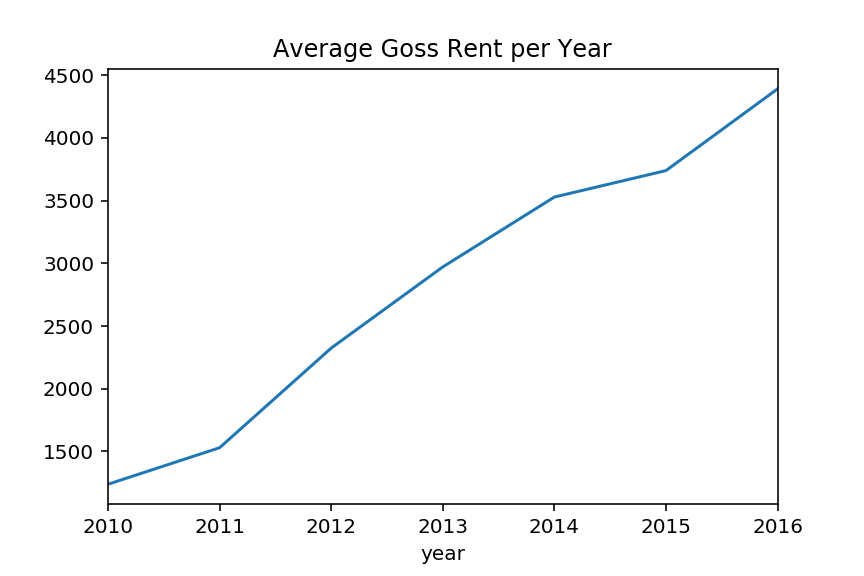
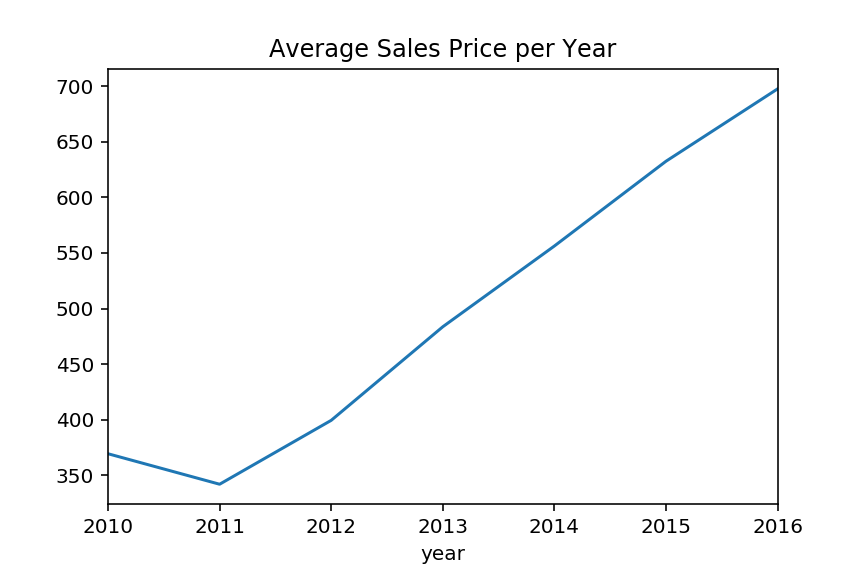
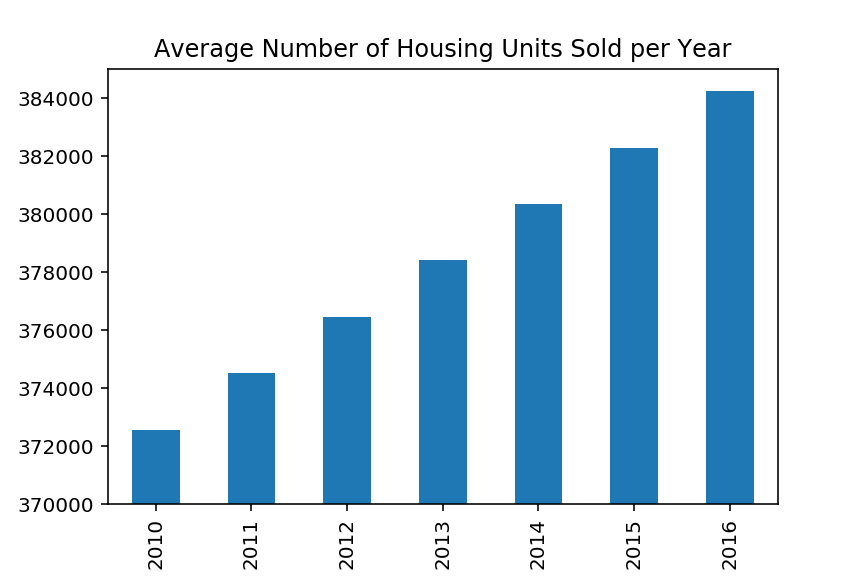

In [15]:
SF_dashboard.servable()